# Project: Intro to Big Data Analytics (INFT-4836)
## Healthcare Data Mining for Disease Prediction with PySpark
### Team Members:
**Laman Panakhova,**
**Shahla Azizova,**
**Khadija Ahmadova,**
**Mahbuba Jafarzada,**
**Emil Hajiyev**

#### School of Information Technologies and Engineering, ADA University, Baku, Azerbaijan


## INTRODUCTION 
----------------------------------------------------------
In this notebook, we’ll be building a **Medical Disease Prediction** system using **PySpark**, **Random Forest**, and **Machine Learning Pipelines**. By the end, we’ll have a complete system for predicting diseases based on medical data. 

### Here's a breakdown of what we’re doing:
1. **Setting Up the Environment**  
   First, we’ll install the necessary libraries and import the modules we’ll need for the project.
2. **Creating a Spark Session**  
   We'll create a Spark session. This is like the engine that runs all the operations we’ll be doing in PySpark.
3. **Loading the Data**  
   Next, we load the dataset that we’ll use to train our model. This dataset contains medical information, including disease diagnoses.
4. **Cleaning & Normalizing Data**  
   Here, we make sure the data is clean. We’ll fix any weird column names and make them consistent so the model can understand everything properly.
5. **Fixing the Label Column (`prognosis`)**  
   We’ll check the label column (which is the disease prognosis) and make sure it’s correctly formatted. If there’s anything wrong, we’ll fix it.
6. **Handling Missing Values & Type Casting**  
   If there are any missing values in the data, we’ll deal with them. Also, we need to make sure the data types are correct, so we’ll handle any type casting that’s needed.
7. **Label Encoding (StringIndexer)**  
   We’ll use **StringIndexer** to convert the disease names (which are text) into numbers, so our model can understand them.
8. **Feature Selection & Vector Assembly**  
   We’ll select the most important features (the ones that actually matter for predicting the disease), and then combine them into a vector that can be used by the model.
9. **Training Random Forest with Cross-Validation**  
   This is where we train our **Random Forest** model. We’ll also use **cross-validation** to check how well the model performs and make sure it’s not overfitting.
10. **Evaluating the Model**  
   Once the model is trained, we’ll evaluate it to see how well it predicts diseases. We’ll check accuracy and other metrics.
11. **Visualizing Results**  
   To make things clearer, we’ll plot some graphs to visualize how well our model did and what patterns we can see in the data.
12. **Saving the Model**  
   Finally, we’ll save the trained model so we can use it later for predictions.

#### Why?, What?, How?
Each step includes a **Why?**, **What?**, and **How?** to make sure you understand:
- **Why** we’re doing each task
- **What** we’re actually doing
- **How** we’re doing it, including the specific methods or functions we use

This way, you'll not only follow the steps but also understand the reasoning behind each one. It’ll help you get a clearer idea of how to apply these techniques to your own projects in the future!

### Install & Import Dependencies
##### What we do:
- First, we’ll **install seaborn** (a cool library for making pretty plots).
- Then, we **import** the libraries we need:
  - **PySpark** for working with big data and running ML models.
  - **Pandas** and **NumPy** for data manipulation and numerical operations.
  - **Matplotlib** and **Seaborn** for plotting graphs and visualizing results.
  - **ML components** from PySpark that will help us build and train our models.
- Finally, we’ll **configure plotting settings** to make sure our plots look nice.
##### Why we do it:
We need these libraries for the entire pipeline, from data processing to model building and visualization. Without them, we wouldn’t be able to run the machine learning algorithms or visualize our results.
##### How it helps:
By installing and importing everything at the start, we make sure there are no import errors later on. It sets up the environment, so we don’t run into problems when we start coding the actual model and visualizations.


In [2]:
!pip install seaborn
# Cell 1 — Environment & imports
# Run this first cell.
import os
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType, DoubleType

# PySpark ML
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# For visualization and metrics (convert to pandas)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

print("Libraries imported.")


Libraries imported.


### Start Spark Session
##### What we do:
- We **initialize a SparkSession** and set shuffle partition settings to optimize performance.
##### Why we do it:
- Spark is essential for distributed processing, allowing us to handle large datasets efficiently.
##### How it helps:
- We use `SparkSession.builder` to set up Spark, which is the foundation for all Spark operations in the notebook.


In [3]:
# Cell 2 — Start Spark session
spark = SparkSession.builder \
    .appName("DiseasePrediction_PySpark_Full") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

print("Spark session:", spark.sparkContext.appName)


Spark session: DiseasePrediction_PySpark_Full


### Set File Paths
##### What we do:
- We **define the exact file paths** for the training and testing CSV files.
##### Why we do it:
- Spark needs the **absolute file paths** to correctly locate and load the data into the environment.
##### How it helps:
- By setting the file paths, we make sure that Spark can find the datasets and use them for training and testing.


In [4]:
# Cell 3 — Paths (use your exact provided paths)
train_path = r"C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Intro to Big Data Analytics (INFT-4836 - 10546)\archive (10)\Training.csv"
test_path  = r"C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Intro to Big Data Analytics (INFT-4836 - 10546)\archive (10)\Testing.csv"

print("Train path:", train_path)
print("Test path: ", test_path)


Train path: C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Intro to Big Data Analytics (INFT-4836 - 10546)\archive (10)\Training.csv
Test path:  C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Intro to Big Data Analytics (INFT-4836 - 10546)\archive (10)\Testing.csv


### Load CSV Files
##### What we do:
- We **load the CSV files** into Spark DataFrames, letting Spark **automatically infer the schema** (data types, column names, etc.).
##### Why we do it:
- This allows us to **inspect the data structure**, check the size of the datasets, and see example rows.
##### How it helps:
- Loading the data as Spark DataFrames gives us a flexible way to work with large datasets, and schema inference makes sure the data types are correct for processing.


In [5]:
# Cell 4 — Read CSVs (infer schema)
train_df = spark.read.csv(train_path, header=True, inferSchema=True)
test_df  = spark.read.csv(test_path, header=True, inferSchema=True)

print("Train rows:", train_df.count(), "columns:", len(train_df.columns))
print("Test rows: ", test_df.count(),  "columns:", len(test_df.columns))

# Show sample
train_df.limit(5).toPandas()


Train rows: 4920 columns: 134
Test rows:  42 columns: 133


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,_c133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,None
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,None
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,None
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,None
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,None


### Clean Column Names
##### What we do:
- We **clean the column names** to remove any invalid characters that might cause issues.
##### Why we do it:
- Certain characters (like spaces or symbols) can break Spark's **VectorAssembler** and ML pipelines.
##### How it helps:
- Cleaning the column names ensures everything works smoothly when we assemble features and build ML models.


In [6]:
# Cell 5 — Clean and normalize column names (both dataframes)
def clean_colname(c):
    c2 = c.strip()
    # replace spaces, slashes, parentheses, percent sign, hyphens, multiple underscores -> single underscore
    c2 = re.sub(r"[ /()+%-]", "_", c2)
    c2 = re.sub(r"__+", "_", c2)
    c2 = c2.strip("_")
    # replace weird characters
    c2 = c2.replace("?", "").replace(",", "").replace("'", "")
    return c2

old_cols = train_df.columns
new_cols = [clean_colname(c) for c in old_cols]

for o, n in zip(old_cols, new_cols):
    if o != n:
        train_df = train_df.withColumnRenamed(o, n)

# Apply same renames to test. We assume training and testing had same original columns (or at least same symptom names).
# If test has slightly different names, map common cleaned names.
test_old = test_df.columns
test_renames = {c: clean_colname(c) for c in test_old}
for o, n in test_renames.items():
    if o != n:
        test_df = test_df.withColumnRenamed(o, n)

print("Example cleaned TRAIN columns (first 20):")
print(train_df.columns[:20])


Example cleaned TRAIN columns (first 20):
['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing', 'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting', 'vomiting', 'burning_micturition', 'spotting_urination', 'fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets', 'mood_swings', 'weight_loss']


### Ensure Prognosis Column Exists
##### What we do:
- We **standardize the "prognosis" column** name and remove any extra spaces around it.
##### Why we do it:
- The label (i.e., **prognosis**) must be the same in both the training and testing data for consistency.
##### How it helps:
- Ensuring the label is consistent across datasets prevents errors when training and testing the model.


In [7]:
# Cell 6 — Ensure 'prognosis' exists and uniform case
# Some datasets may use 'prognosis' or 'prognosis ' etc. Normalize.
if "prognosis" not in train_df.columns:
    # try to find column name containing 'prognosis' ignoring case
    cand = [c for c in train_df.columns if 'prognosis' in c.lower()]
    if len(cand) > 0:
        train_df = train_df.withColumnRenamed(cand[0], "prognosis")
    else:
        raise ValueError("Could not find 'prognosis' column in training data.")

if "prognosis" not in test_df.columns:
    cand = [c for c in test_df.columns if 'prognosis' in c.lower()]
    if len(cand) > 0:
        test_df = test_df.withColumnRenamed(cand[0], "prognosis")
    else:
        raise ValueError("Could not find 'prognosis' column in testing data.")

# Trim strings in prognosis
from pyspark.sql.functions import trim
train_df = train_df.withColumn("prognosis", trim(col("prognosis")))
test_df  = test_df.withColumn("prognosis", trim(col("prognosis")))

print("Unique labels (train):", train_df.select("prognosis").distinct().count())
train_df.select("prognosis").distinct().show(20, truncate=False)


Unique labels (train): 41
+-----------------------+
|prognosis              |
+-----------------------+
|Impetigo               |
|Urinary tract infection|
|Hyperthyroidism        |
|Gastroenteritis        |
|Heart attack           |
|Chronic cholestasis    |
|Tuberculosis           |
|Hypoglycemia           |
|Cervical spondylosis   |
|Hepatitis D            |
|Osteoarthristis        |
|Varicose veins         |
|Diabetes               |
|Migraine               |
|Hepatitis B            |
|Arthritis              |
|Hypertension           |
|Malaria                |
|Hypothyroidism         |
|Chicken pox            |
+-----------------------+
only showing top 20 rows


### Cast Features to Integers
##### What we do:
- We **convert all symptom columns** to integers.
##### Why we do it:
- Machine learning algorithms can't process **strings**; they require all inputs to be **numeric**.
##### How it helps:
- By looping through the feature columns and casting each one to **IntegerType**, we ensure that the model can process the data correctly.


In [8]:
# Cell 7 — Make sure symptom columns are numeric (0/1). Convert string '1' or '0' to integers if needed.
# Identify feature columns: all columns except prognosis
feature_cols = [c for c in train_df.columns if c != "prognosis"]

# Cast features to integer (safe: if already ints nothing changes)
for c in feature_cols:
    train_df = train_df.withColumn(c, col(c).cast(IntegerType()))
    # For tests also
    if c in test_df.columns:
        test_df = test_df.withColumn(c, col(c).cast(IntegerType()))

# Check for nulls in features
null_summary = [(c, train_df.filter(col(c).isNull()).count()) for c in feature_cols]
null_summary = [t for t in null_summary if t[1] > 0]
print("Columns with nulls in TRAIN (name, null_count):", null_summary)
# If nulls exist, you may fill them with 0 (assume missing symptom = absent)
if len(null_summary) > 0:
    for c, _ in null_summary:
        train_df = train_df.fillna({c: 0})
        if c in test_df.columns:
            test_df = test_df.fillna({c: 0})


Columns with nulls in TRAIN (name, null_count): [('c133', 4920)]


### Label Encoding Using StringIndexer
##### What we do:
- We **convert the prognosis labels** (which are strings) into **numeric index labels**.
##### Why we do it:
- Machine learning models require **numeric labels** to process the data and make predictions.
##### How it helps:
- We use **StringIndexer** to **fit** on the training data and then **transform** both the training and test datasets into numeric labels.


In [9]:
# Cell 8 — Label encoding: fit StringIndexer on training prognosis and reuse on test
label_indexer = StringIndexer(inputCol="prognosis", outputCol="label").fit(train_df)
train_indexed = label_indexer.transform(train_df)
test_indexed = label_indexer.transform(test_df)  # uses same mapping; unseen labels in test will be handled by 'keep' default? if unseen raise.

# Show mapping (labels -> indices)
labels = label_indexer.labels  # list of labels in order of index (0 -> labels[0])
print("Label indexer labels (index -> label):")
for idx, lab in enumerate(labels):
    print(idx, lab)

# Check label distribution
train_indexed.groupBy("label", "prognosis").count().orderBy("label").show(50, truncate=False)


Label indexer labels (index -> label):
0 (vertigo) Paroymsal  Positional Vertigo
1 AIDS
2 Acne
3 Alcoholic hepatitis
4 Allergy
5 Arthritis
6 Bronchial Asthma
7 Cervical spondylosis
8 Chicken pox
9 Chronic cholestasis
10 Common Cold
11 Dengue
12 Diabetes
13 Dimorphic hemmorhoids(piles)
14 Drug Reaction
15 Fungal infection
16 GERD
17 Gastroenteritis
18 Heart attack
19 Hepatitis B
20 Hepatitis C
21 Hepatitis D
22 Hepatitis E
23 Hypertension
24 Hyperthyroidism
25 Hypoglycemia
26 Hypothyroidism
27 Impetigo
28 Jaundice
29 Malaria
30 Migraine
31 Osteoarthristis
32 Paralysis (brain hemorrhage)
33 Peptic ulcer diseae
34 Pneumonia
35 Psoriasis
36 Tuberculosis
37 Typhoid
38 Urinary tract infection
39 Varicose veins
40 hepatitis A
+-----+---------------------------------------+-----+
|label|prognosis                              |count|
+-----+---------------------------------------+-----+
|0.0  |(vertigo) Paroymsal  Positional Vertigo|120  |
|1.0  |AIDS                                   |120  |
|

### Feature Selection
##### What we do:
- We **extract only the numeric symptom columns** to use as features for the model.
##### Why we do it:
- Non-numeric columns can **break the VectorAssembler** and cause errors in the ML model.
##### How it helps:
- We **filter the columns** based on their data type to ensure that only numeric features are passed to the model.


In [10]:
# Cell 9 — Define features list (ensure features exist in both train & test)
# Some rectangular datasets might have extra columns in test not present in train; intersect them.
feature_cols = [c for c in train_indexed.columns if c not in ("prognosis", "label")]

# Filter out any non-symptom columns accidentally included (e.g., index column)
# Keep only columns that are numeric (int/double)
numeric_cols = []
for c, dtype in train_indexed.dtypes:
    if c in feature_cols and dtype in ('int', 'bigint', 'double', 'float', 'tinyint'):
        numeric_cols.append(c)

feature_cols = numeric_cols
print("Number of feature columns used:", len(feature_cols))
print("Example features (first 30):", feature_cols[:30])


Number of feature columns used: 133
Example features (first 30): ['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing', 'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting', 'vomiting', 'burning_micturition', 'spotting_urination', 'fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets', 'mood_swings', 'weight_loss', 'restlessness', 'lethargy', 'patches_in_throat', 'irregular_sugar_level', 'cough', 'high_fever', 'sunken_eyes', 'breathlessness', 'sweating', 'dehydration']


### VectorAssembler & Column Alignment
##### What we do:
- We ensure that both **Train** and **Test** datasets have **identical feature columns**, then assemble all the symptoms into a single **"features"** vector.
##### Why we do it:
- ML models will **fail** if the training and testing datasets have **mismatched columns**.
##### How it helps:
- We **add missing columns** to the test dataset, **drop any extra ones**, and then use **VectorAssembler** to combine the symptom columns into a single vector for model input.


In [11]:
# === FIXED CELL 10 — Assemble features vector safely ===

# 1. Ensure test has all feature columns
train_features = set(feature_cols)
test_features = set(test_indexed.columns) - {"prognosis", "label"}

# Columns missing in test -> add them with default value 0
missing_in_test = train_features - test_features
for c in missing_in_test:
    test_indexed = test_indexed.withColumn(c, lit(0))

# Extra columns in test not in train -> drop them
extra_in_test = test_features - train_features
for c in extra_in_test:
    test_indexed = test_indexed.drop(c)

# 2. Recreate feature list with columns that DEFINITELY exist in both datasets
final_features = [c for c in feature_cols if c in test_indexed.columns]

print("Original training feature count:", len(feature_cols))
print("Final aligned feature count:   ", len(final_features))
print("Missing features added to test:", len(missing_in_test))
print("Dropped extra features:", len(extra_in_test))

# 3. Create VectorAssembler using aligned feature list
assembler = VectorAssembler(
    inputCols=final_features,
    outputCol="features",
    handleInvalid="keep"
)

# 4. Transform both datasets
train_ready = assembler.transform(train_indexed).select("features", "label", "prognosis")
test_ready = assembler.transform(test_indexed).select("features", "label", "prognosis")

print("Prepared train/test data:")
print("Train count:", train_ready.count(), 
      "Test count:", test_ready.count())


Original training feature count: 133
Final aligned feature count:    133
Missing features added to test: 1
Dropped extra features: 0
Prepared train/test data:
Train count: 4920 Test count: 42


### Train Random Forest with Cross-Validation
##### What we do:
- We **train a RandomForestClassifier** with **hyperparameter tuning** using cross-validation.
##### Why we do it:
- **Cross-validation** helps improve the model's ability to generalize and selects the best hyperparameters for better performance.
##### How it helps:
- We use **CrossValidator** with **ParamGridBuilder** to search through different hyperparameters, and perform **3-fold cross-validation** to ensure the model performs well on unseen data.


In [12]:
# Cell 11 — Train RandomForest with CrossValidator (3-fold CV)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100, 200]) \
    .addGrid(rf.maxDepth, [8, 16]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=2)

print("Starting cross-validated training (may take a while)...")
cvModel = cv.fit(train_ready)
bestModel = cvModel.bestModel
print("Best model params -> numTrees:", bestModel.getNumTrees, " maxDepth:", bestModel.getOrDefault("maxDepth"))


Starting cross-validated training (may take a while)...
Best model params -> numTrees: 100  maxDepth: 16


### Predictions on Test Set
##### What we do:
- We **run the best model** to predict diseases on the test dataset.
##### Why we do it:
- To **evaluate** the model, we need to generate **predictions** on the test data.
##### How it helps:
- We use `.transform(test_ready)` to apply the trained model and get predictions on the test set.


In [13]:
# Cell 12 — Predictions on test set
pred = bestModel.transform(test_ready)
pred.select("prognosis", "label", "prediction", "features").limit(10).toPandas()


,prognosis,label,prediction,features
0,Fungal infection,15.0,15.0,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Allergy,4.0,4.0,"(0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
2,GERD,16.0,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
3,Chronic cholestasis,9.0,9.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Drug Reaction,14.0,14.0,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
5,Peptic ulcer diseae,33.0,33.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,AIDS,1.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Diabetes,12.0,12.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Gastroenteritis,17.0,17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Bronchial Asthma,6.0,6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Evaluate Model Metrics
##### What we do:
- We **calculate metrics** like **accuracy**, **F1**, **precision**, and **recall** to evaluate the model’s performance.
##### Why we do it:
- These **quality measures** help us understand how well the classifier is performing.
##### How it helps:
- We use **MulticlassClassificationEvaluator** to compute these metrics and get a clearer picture of the model’s strengths and weaknesses.


In [14]:
# Cell 13 — Evaluate predictions with multiple metrics
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

accuracy = accuracy_evaluator.evaluate(pred)
f1 = f1_evaluator.evaluate(pred)
precision = precision_evaluator.evaluate(pred)
recall = recall_evaluator.evaluate(pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 (weighted): {f1:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")


Test Accuracy: 0.9762
Test F1 (weighted): 0.9762
Test Precision (weighted): 0.9881
Test Recall (weighted): 0.9762


### Convert Predictions to Pandas & Create Report
##### What we do:
- We **convert the Spark predictions** into **Pandas DataFrame** and then generate a **classification report**.
##### Why we do it:
- **Sklearn's** reporting functions only work with **Pandas arrays**, so we need to convert the data for easier evaluation.
##### How it helps:
- We **map the label indices** back to the original **prognosis strings**, so the report is more readable and understandable.


In [15]:
# Cell 14 — Convert predictions to pandas for detailed report & confusion matrix
# Warning: if test set is huge, toPandas may be heavy. Your dataset is modest so it should be fine.
pred_pd = pred.select("prognosis", "label", "prediction").toPandas()
# prediction and label are numeric indices; map indices back to original labels (use label_indexer.labels)
index_to_label = {i: label for i,label in enumerate(label_indexer.labels)}
pred_pd["label_name"] = pred_pd["label"].map(index_to_label)
pred_pd["pred_name"] = pred_pd["prediction"].map(index_to_label)

# Classification report
print("Sklearn classification report (by label names):")
print(classification_report(pred_pd["label_name"], pred_pd["pred_name"], zero_division=0))


Sklearn classification report (by label names):
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       0.50      1.00      0.67         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.00      1.00

### Confusion Matrix Plot
##### What we do:
- We **visualize the confusion matrix** to see how well the model is distinguishing between diseases.
##### Why we do it:
- It helps us understand which diseases are **commonly confused** by the model, giving us insights into areas of improvement.
##### How it helps:
- We use **seaborn’s heatmap** along with **sklearn’s confusion_matrix** to plot and visualize the results in an easy-to-read format.


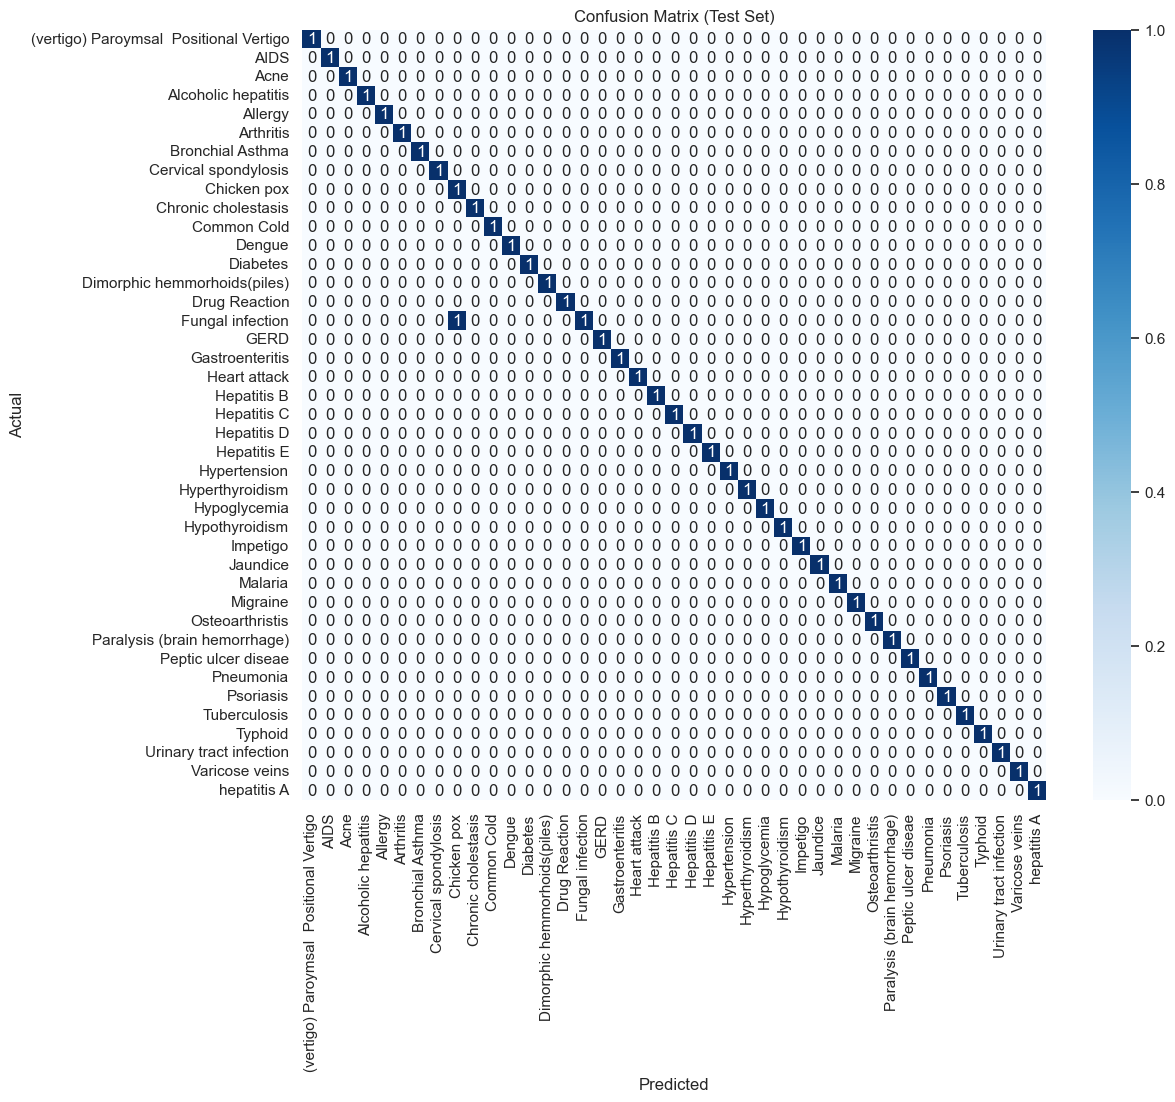

In [16]:
# Cell 15 — Confusion matrix (visual)
cm = confusion_matrix(pred_pd["label_name"], pred_pd["pred_name"], labels=label_indexer.labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_indexer.labels, yticklabels=label_indexer.labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


### Feature Importances
##### What we do:
- We **display the top 30 most important symptoms** based on the model’s feature importances.
##### Why we do it:
- Understanding which symptoms are most important helps us **interpret the model’s decision-making** and focus on the most relevant features.
##### How it helps:
- We **extract feature importances** from the trained **RandomForest model** to identify which features have the biggest impact on predictions.


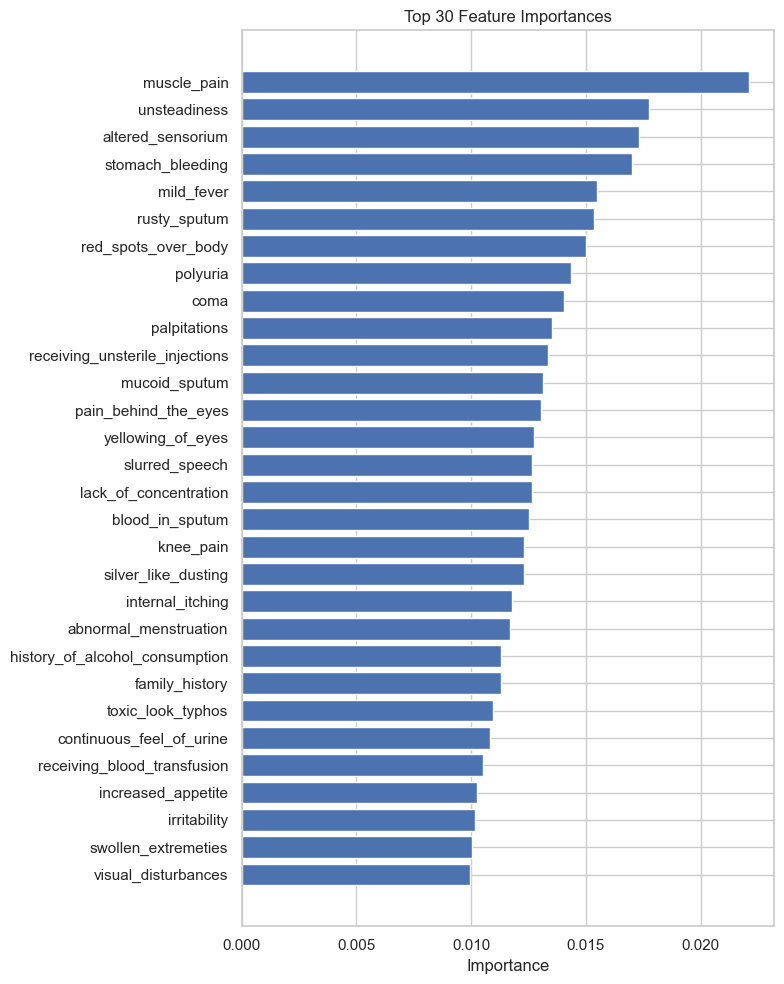

,feature,importance
0,muscle_pain,0.022095
1,unsteadiness,0.017738
2,altered_sensorium,0.017337
3,stomach_bleeding,0.017010
4,mild_fever,0.015493
5,rusty_sputum,0.015344
6,red_spots_over_body,0.015019
7,polyuria,0.014352
8,coma,0.014048
9,palpitations,0.013516


In [17]:
# Cell 16 — Feature importances (top 30 symptoms)
importances = bestModel.featureImportances.toArray()
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

top_n = 30
top_feat = feat_imp.head(top_n).iloc[::-1]  # reverse for horizontal bar chart
plt.figure(figsize=(8,10))
plt.barh(top_feat["feature"], top_feat["importance"])
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Also display top 30 as table
top_feat_table = feat_imp.head(top_n)
top_feat_table.reset_index(drop=True, inplace=True)
top_feat_table


### Save Model & Outputs
##### What we do:
- We **save the model**, **predictions**, and **feature importances** to disk.
##### Why we do it:
- This allows us to **reuse the trained model** later or **share the results** with others.
##### How it helps:
- We **write the Spark model** and the **CSV files** with predictions and feature importances to an output folder for easy access.


In [18]:
import os
import pandas as pd
from pyspark.sql.functions import when, lit
from pyspark.sql.types import StringType

# Define the output directory
output_dir = r"C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Intro to Big Data Analytics (INFT-4836 - 10546)\disease_model_outputs"
os.makedirs(output_dir, exist_ok=True)

# Save Spark model
model_path = os.path.join(output_dir, "rf_disease_model_spark")
bestModel.write().overwrite().save(model_path)
print("Saved Spark RF model to:", model_path)

# Save predictions (as CSV)
pred_out = pred.select("prognosis", "label", "prediction")
pred_out = pred_out.withColumn("pred_name", when(col("prediction").isNotNull(), lit("X")).cast(StringType()))  # placeholder to allow toPandas
# We'll use the pandas pred_pd mapping for a clean CSV
pred_pd.to_csv(os.path.join(output_dir, "predictions_test.csv"), index=False)
print("Saved predictions CSV to:", os.path.join(output_dir, "predictions_test.csv"))

# Show the rows of the predictions CSV
pred_df = pd.read_csv(os.path.join(output_dir, "predictions_test.csv"))
print("Rows from predictions_test.csv:")
print(pred_df.head(10))  # Show the first 5 rows, you can adjust as needed

# Save feature importances
top_feat_table.to_csv(os.path.join(output_dir, "feature_importances_top30.csv"), index=False)
print("Saved feature importances to:", os.path.join(output_dir, "feature_importances_top30.csv"))

# Show the rows of the feature importances CSV
feature_importances_df = pd.read_csv(os.path.join(output_dir, "feature_importances_top30.csv"))
print("Rows from feature_importances_top30.csv:")
print(feature_importances_df.head(10))  # Show the first 5 rows, you can adjust as needed


Saved Spark RF model to: C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Intro to Big Data Analytics (INFT-4836 - 10546)\disease_model_outputs\rf_disease_model_spark
Saved predictions CSV to: C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Intro to Big Data Analytics (INFT-4836 - 10546)\disease_model_outputs\predictions_test.csv
Rows from predictions_test.csv:
             prognosis  label  prediction           label_name  \
0     Fungal infection   15.0        15.0     Fungal infection   
1              Allergy    4.0         4.0              Allergy   
2                 GERD   16.0        16.0                 GERD   
3  Chronic cholestasis    9.0         9.0  Chronic cholestasis   
4        Drug Reaction   14.0        14.0        Drug Reaction   
5  Peptic ulcer diseae   33.0        33.0  Peptic ulcer diseae   
6                 AIDS    1.0         1.0                 AIDS   
7             Diabetes   12.0        12.0             Dia

### Summary Output

##### What we do:
- We **print summary information** at the end of the process.
##### Why we do it:
- This helps us **verify** the **dataset size**, **feature count**, and check the **output directory** to ensure everything is correct.
##### How it helps:
- We **display counts** of records and features, as well as the **directory path** where the results are saved.


In [19]:
# Cell 18 — Short summary and cleanup
print("SUMMARY:")
print(f"Train rows: {train_df.count()}, Test rows: {test_df.count()}")
print(f"Number of features used: {len(feature_cols)}")
print(f"Output directory: {output_dir}")

# If you want to stop Spark at the end uncomment next line:
# spark.stop()


SUMMARY:
Train rows: 4920, Test rows: 42
Number of features used: 133
Output directory: C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Intro to Big Data Analytics (INFT-4836 - 10546)\disease_model_outputs


### FINAL VISUALIZATION CELL — Medical Dashboard
##### What we do:
- We generate **7 key visualizations**:
  1. Disease distribution
  2. Symptom frequency
  3. Correlation heatmap
  4. Train vs Test distributions
  5. Feature importance chart
  6. Boxplot of symptoms per patient
  7. Symptom–disease heatmap
##### Why we do it:
- **Visualizations** help us gain deeper insights into **dataset patterns** and the **model's behavior**.
##### How it helps:
- We **convert Spark DataFrames to Pandas**, then use **Matplotlib** and **Seaborn** to create the plots and display the results.


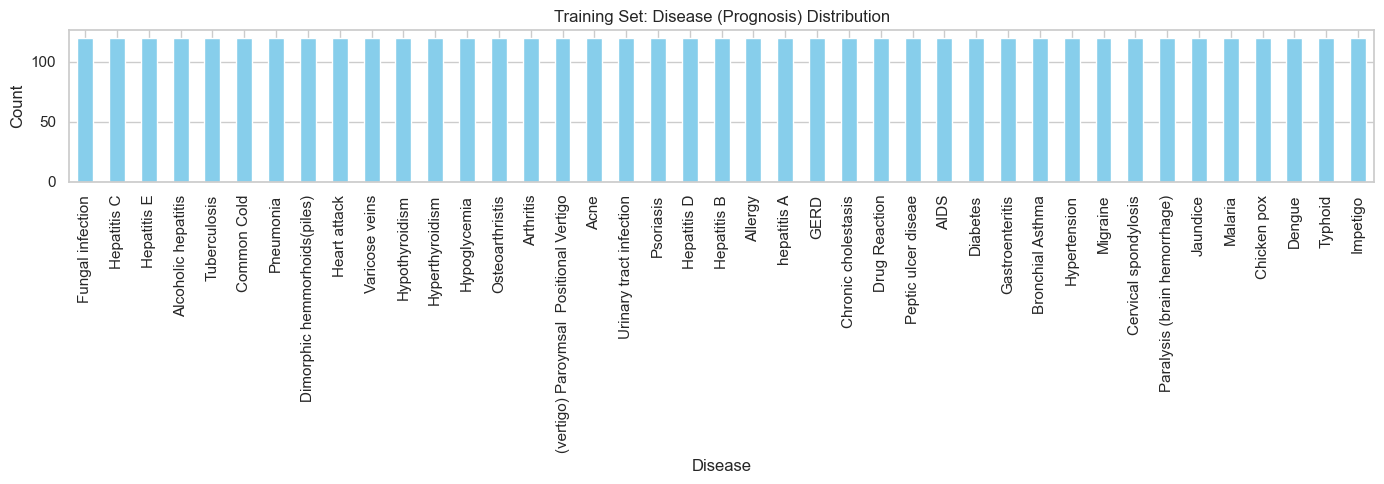

C:\Users\HP\AppData\Local\Temp\ipykernel_20772\2814387665.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=symptom_sums.index[:20], y=symptom_sums.values[:20], palette="viridis")


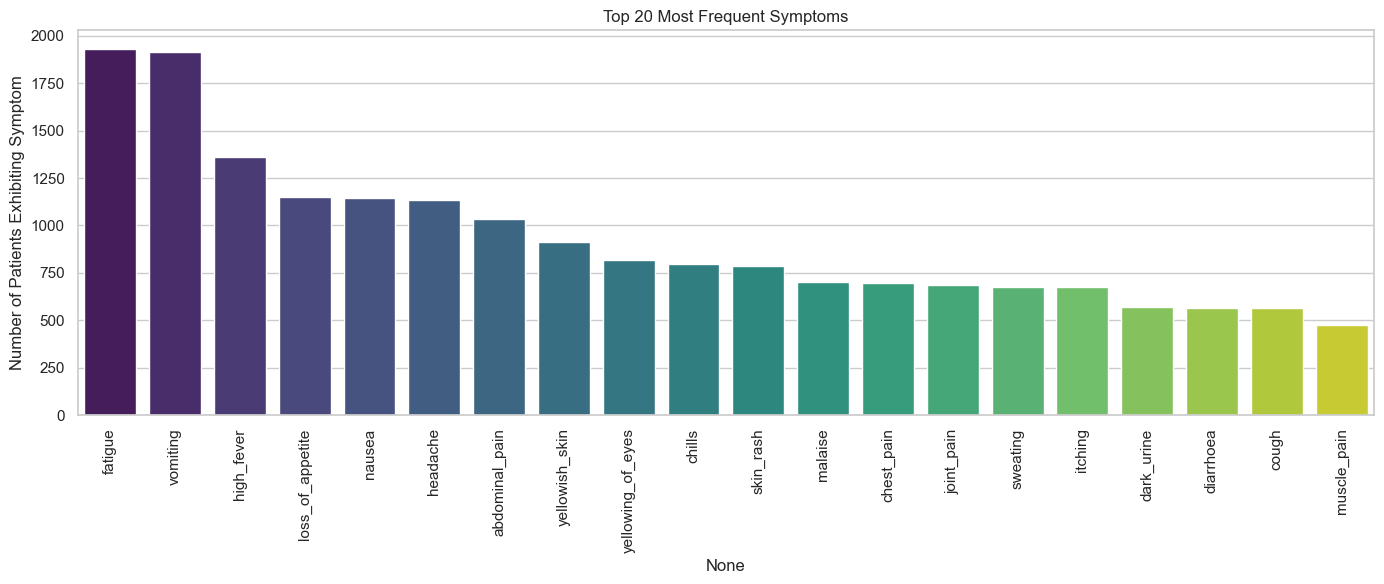

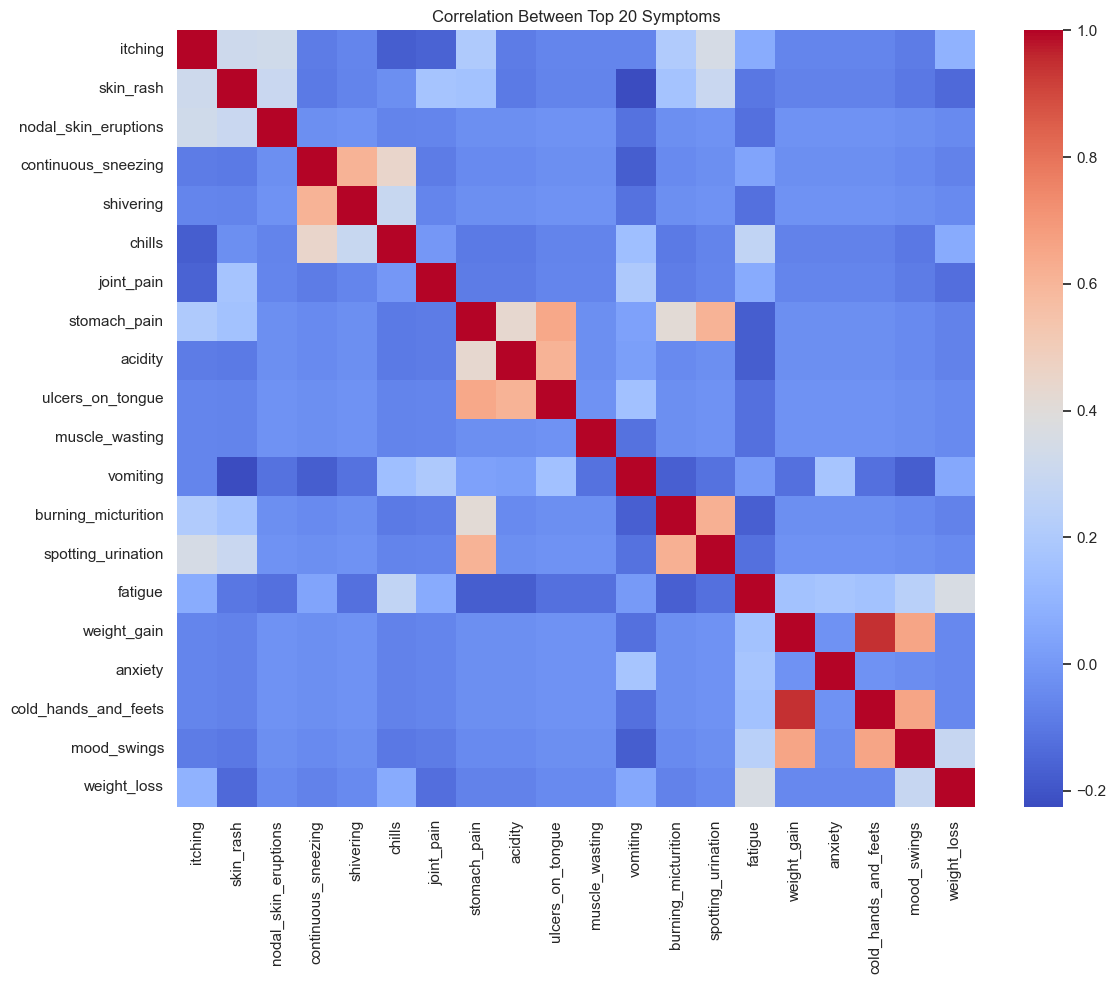

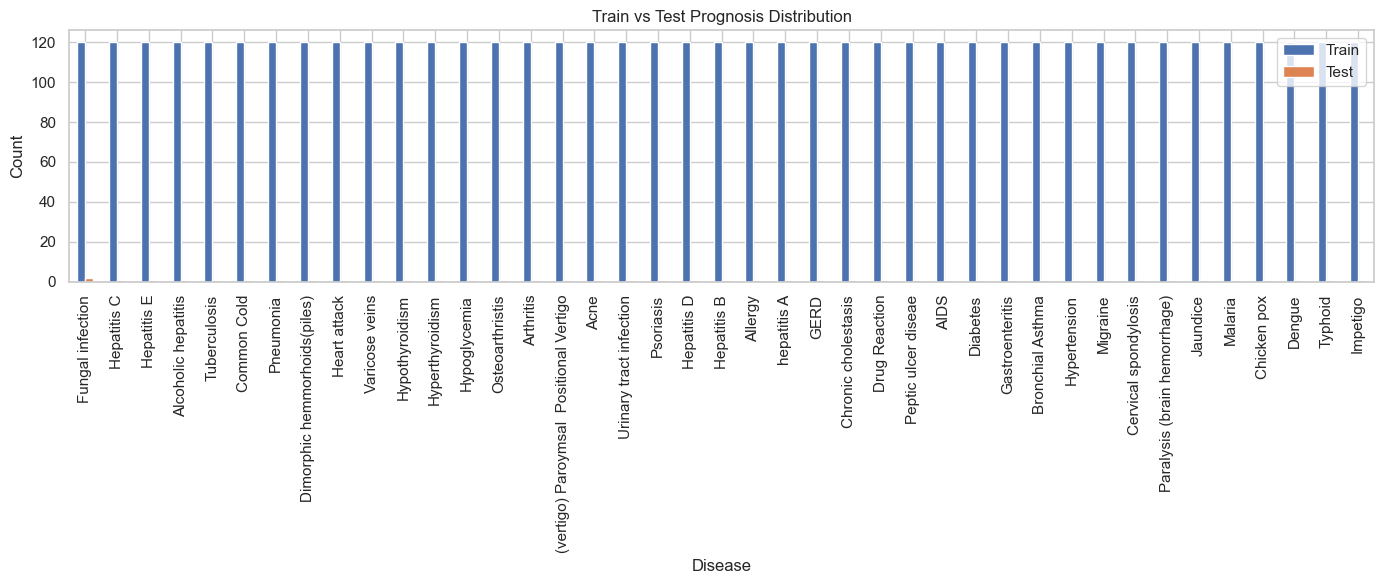

C:\Users\HP\AppData\Local\Temp\ipykernel_20772\2814387665.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_imp, palette="magma")


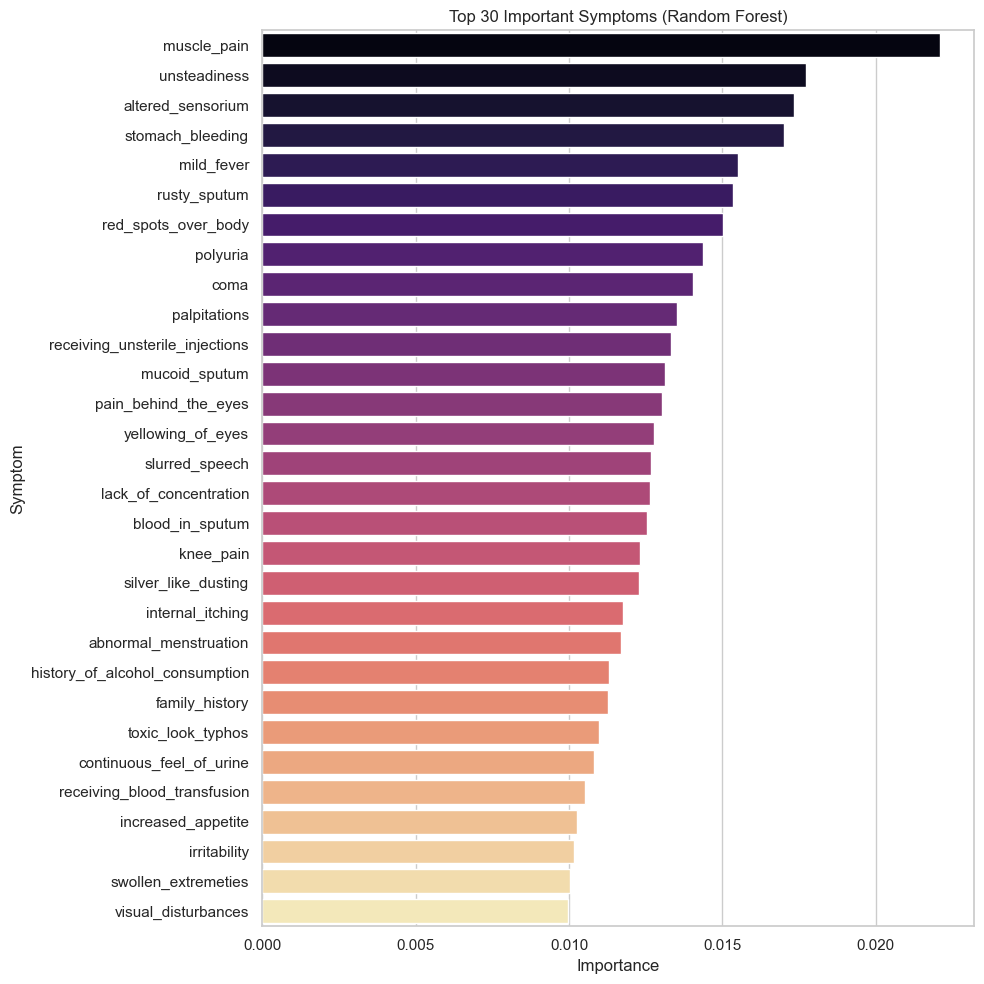

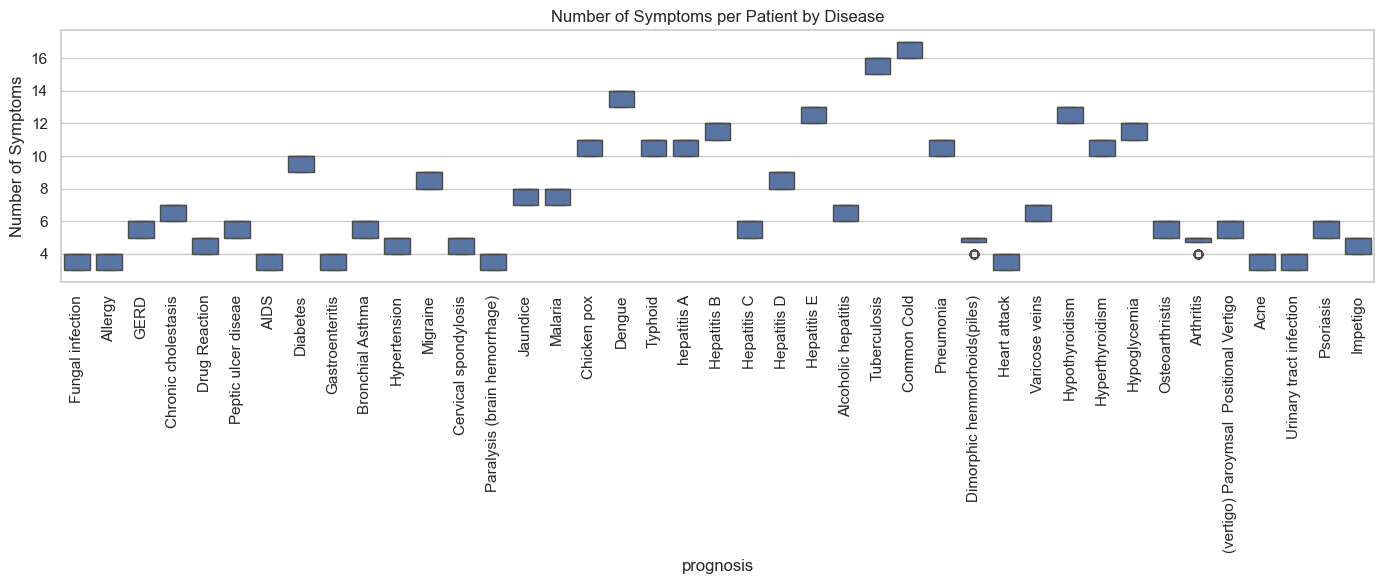

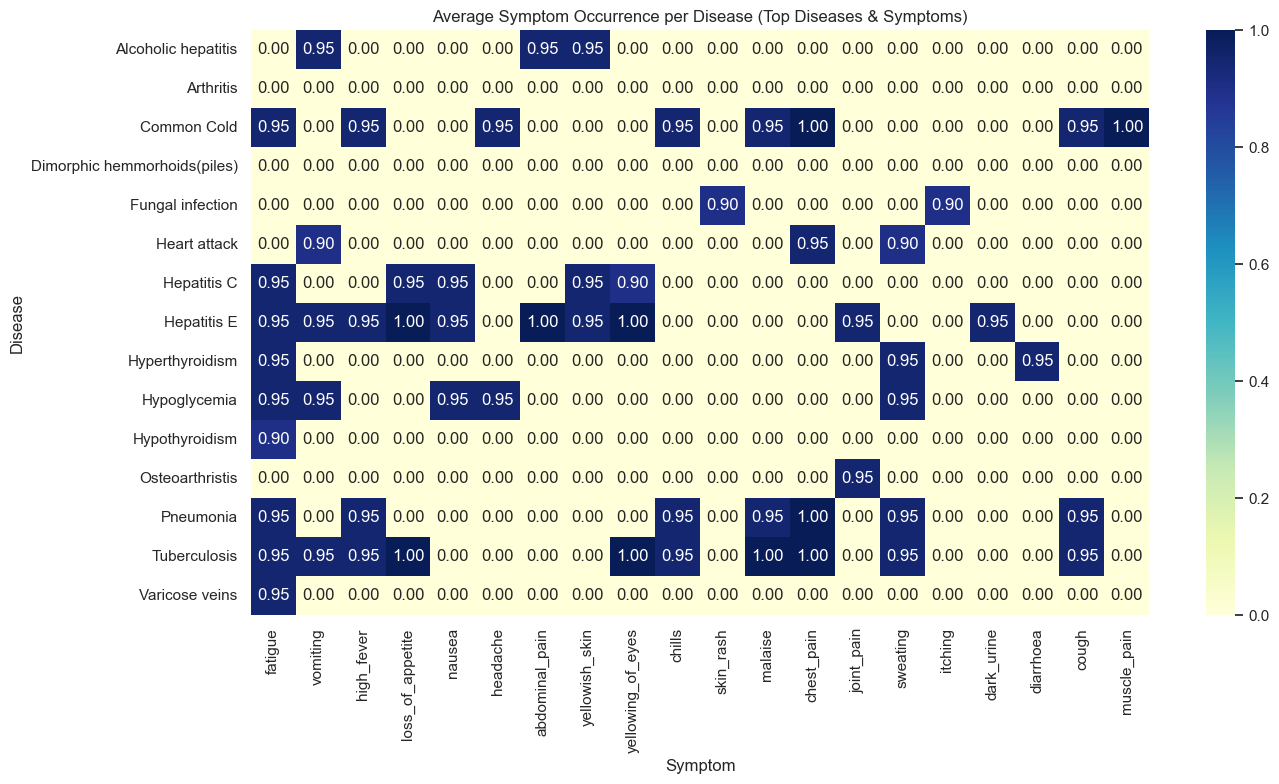

In [20]:
# Meaningful visualizations for Medical Symptoms project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# ------------------- Convert Spark to Pandas -------------------
# Use train_indexed (or train_df) for individual symptom columns
train_pdf = train_indexed.select("prognosis", *feature_cols).toPandas()
test_pdf  = test_indexed.select("prognosis", *feature_cols).toPandas()

# ------------------- 1. Prognosis distribution -------------------
plt.figure(figsize=(14,5))
train_pdf['prognosis'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Training Set: Disease (Prognosis) Distribution")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ------------------- 2. Top 20 symptoms frequency -------------------
symptom_sums = train_pdf[feature_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=symptom_sums.index[:20], y=symptom_sums.values[:20], palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 20 Most Frequent Symptoms")
plt.ylabel("Number of Patients Exhibiting Symptom")
plt.tight_layout()
plt.show()

# ------------------- 3. Symptom co-occurrence heatmap -------------------
corr_matrix = train_pdf[feature_cols[:20]].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Between Top 20 Symptoms")
plt.tight_layout()
plt.show()

# ------------------- 4. Train vs Test disease distribution -------------------
merged = pd.DataFrame({
    "Train": train_pdf['prognosis'].value_counts(),
    "Test": test_pdf['prognosis'].value_counts()
}).fillna(0)
merged.plot(kind='bar', figsize=(14,6))
plt.title("Train vs Test Prognosis Distribution")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ------------------- 5. Random Forest Feature Importance -------------------
importances = bestModel.featureImportances.toArray()
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False).head(30)

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=feat_imp, palette="magma")
plt.title("Top 30 Important Symptoms (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()

# ------------------- 6. Disease vs Number of Symptoms per patient -------------------
train_pdf['num_symptoms'] = train_pdf[feature_cols].sum(axis=1)
plt.figure(figsize=(14,6))
sns.boxplot(x='prognosis', y='num_symptoms', data=train_pdf)
plt.xticks(rotation=90)
plt.title("Number of Symptoms per Patient by Disease")
plt.ylabel("Number of Symptoms")
plt.tight_layout()
plt.show()

# ------------------- 7. Symptom occurrence per disease (heatmap) -------------------
top_diseases = train_pdf['prognosis'].value_counts().head(15).index
top_symptoms = symptom_sums.index[:20]
heat_data = train_pdf[train_pdf['prognosis'].isin(top_diseases)].groupby('prognosis')[top_symptoms].mean()

plt.figure(figsize=(14,8))
sns.heatmap(heat_data, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("Average Symptom Occurrence per Disease (Top Diseases & Symptoms)")
plt.ylabel("Disease")
plt.xlabel("Symptom")
plt.tight_layout()
plt.show()


### CONCLUSION — Full End-to-End PySpark Pipeline Complete
##### What we’ve accomplished:
We’ve built a **complete end-to-end pipeline** for predicting medical diseases using **PySpark**, **Random Forest**, and **Machine Learning Pipelines**.

##### Why it matters:
This process gives us the tools to handle large datasets, train models, and evaluate performance, all while making the predictions more interpretable with visualizations.

##### What’s next:
Now that the model is trained, we can **reuse** it for future predictions, fine-tune hyperparameters, or apply the pipeline to other datasets to explore different disease predictions.
